#Класифікація мінералів за допомогою Inception

In [ ]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.applications import InceptionV3
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import zipfile

# Розархівування набору даних
local_zip = './minerals.zip'  # Назва вашого архіву
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./base_minerals')  # Шлях для розархівованих даних
zip_ref.close()


In [ ]:
import os
import shutil
import random

# Шляхи до вихідного і цільового набору даних
original_dataset_dir = './base_minerals/minerals'
base_dir = 'minerals_gen'

# Створення папок для train, validation та test
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Функція для розподілу файлів по вибірках
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)

    train_split = int(len(files) * 0.7)
    val_split = int(len(files) * 0.85)

    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), train_dir)
    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), val_dir)
    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), test_dir)

# Розподіл файлів для кожного класу
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        split_data(
            class_dir,
            os.path.join(base_dir, 'train', class_name),
            os.path.join(base_dir, 'validation', class_name),
            os.path.join(base_dir, 'test', class_name)
        )

print("Файли успішно розподілені на вибірки!")


Файли успішно розподілені на вибірки!


In [ ]:
#Підготовка генераторів даних
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 663 images belonging to 7 classes.
Found 143 images belonging to 7 classes.
Found 146 images belonging to 7 classes.


In [ ]:
# Шлях до директорії навчальних даних
train_dir = './minerals_gen/train'

# Визначення кількості класів
classes_num = len(os.listdir(train_dir))

# Завантаження базової моделі InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Побудова моделі
x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(classes_num, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=x)

# Компіляція моделі
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

In [ ]:
# Навчання моделі та її зберігання
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

model.save('minerals_classification_EXP2.h5')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.1406 - loss: 2.1903 - val_accuracy: 0.2308 - val_loss: 2.1174
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 419ms/step - accuracy: 0.1854 - loss: 2.0250 - val_accuracy: 0.2867 - val_loss: 1.8918
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.2328 - loss: 2.0016 - val_accuracy: 0.3147 - val_loss: 1.7576
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 471ms/step - accuracy: 0.2717 - loss: 1.8361 - val_accuracy: 0.3497 - val_loss: 1.6843
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.3195 - loss: 1.7412 - val_accuracy: 0.3776 - val_loss: 1.6364
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step - accuracy: 0.3903 - loss: 1.6672 - val_accuracy: 0.4056 - val_loss: 1.5712
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 423ms/step - accuracy: 0.3855 - loss: 1.6112 - val_accuracy: 0.4476 - val_loss: 1.5159
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.4055 - loss: 1.5950 - val_accuracy: 0.4615 

In [ ]:
# Оцінка моделі на тестових даних
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Тестова втрата: {test_loss:.4f}")
print(f"Тестова точність: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.6323 - loss: 1.0550
Тестова втрата: 0.9929
Тестова точність: 0.6562


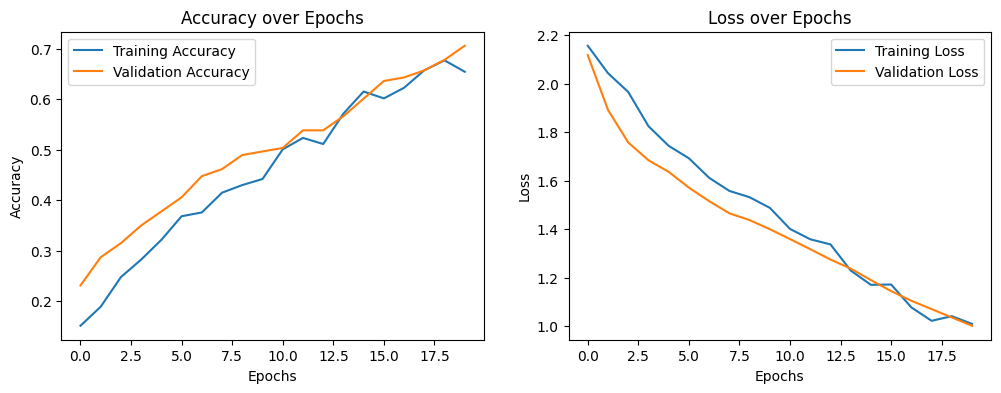

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()